# **Kernel Density Based Clustering**

*   Rohan Niranjan Kalpavruksha
*   Roshan Niranjan Kalpavruksha

## COMPARING **DBSCAN** WITH **VARIOUS KERNEL's** DENSITY BASED CLUSTERING

## 1. DBSCAN

Silhouette Score: 0.637


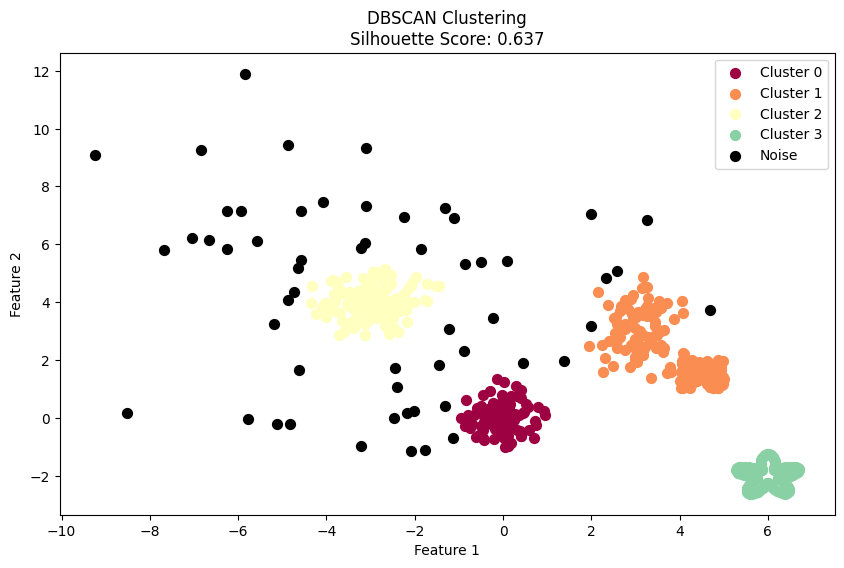

In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Set random seed
np.random.seed(42)

# Generate datasets - A mixture of spherical, elongated, rectangular, sharp edge with varying density data points.
spherical_data = np.random.normal(loc=[0, 0], scale=0.5, size=(100, 2))
elongated_data = np.random.normal(loc=[3, 3], scale=[0.5, 1.0], size=(100, 2))
varying_density_data = np.vstack([np.random.normal(loc=[-3, 4], scale=0.5, size=(140, 2)),
                                   np.random.normal(loc=[-3, 4], scale=3, size=(60, 2))])
rectangular_data = np.random.uniform(low=[4, 1], high=[5, 2], size=(100, 2))
sharp_edge_data = np.column_stack([6 + 0.5 * (1 + 0.5 * np.sin(np.linspace(0, 10 * np.pi, 100))) * np.cos(np.linspace(0, 2 * np.pi, 100)),
                                    -2 + 0.5 * (1 + 0.5 * np.sin(np.linspace(0, 10 * np.pi, 100))) * np.sin(np.linspace(0, 2 * np.pi, 100))])

# Combine all data points into one dataset
data = np.vstack([spherical_data, elongated_data, varying_density_data, rectangular_data, sharp_edge_data])

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
predicted_labels = dbscan.fit_predict(data)

# Calculate silhouette score (only for non-noise points)
if len(set(predicted_labels) - {-1}) > 1:  # Ensure there is more than one cluster
    silhouette = silhouette_score(data, predicted_labels)
else:
    silhouette = -1  # Not enough clusters to calculate silhouette score
print(f"Silhouette Score: {silhouette:.3f}")

# Visualizing the clusters
plt.figure(figsize=(10, 6))
unique_labels = set(predicted_labels)
cmap = plt.get_cmap('Spectral', len(unique_labels))

for k in unique_labels:
    col = cmap(k) if k != -1 else (0, 0, 0, 1)  # Black for noise
    class_member_mask = (predicted_labels == k)
    plt.scatter(data[class_member_mask, 0], data[class_member_mask, 1],
                s=50, color=col, label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title(f'DBSCAN Clustering\nSilhouette Score: {silhouette:.3f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

## 2. VARIOUS KERNEL's DENSITY BASED CLUSTERING



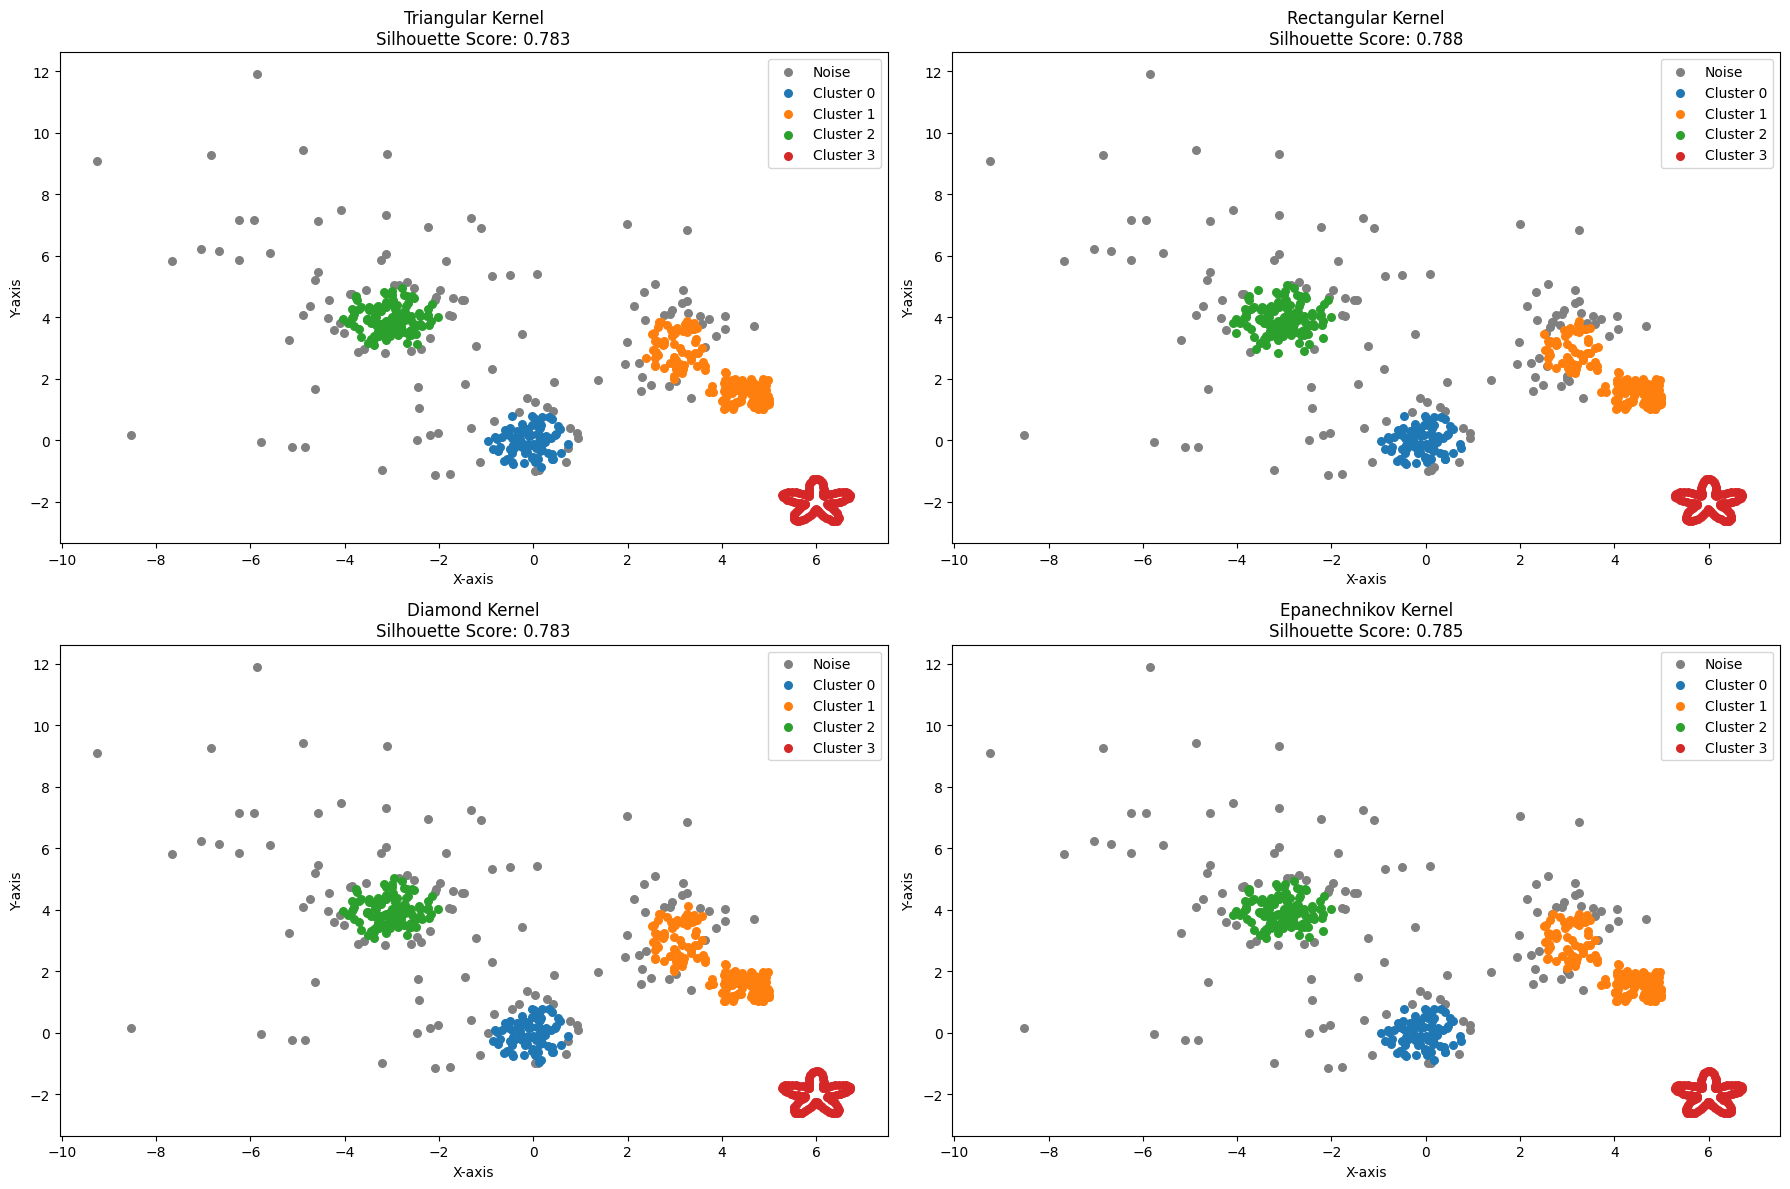

Triangular Kernel - Silhouette Score: 0.783
Rectangular Kernel - Silhouette Score: 0.788
Diamond Kernel - Silhouette Score: 0.783
Epanechnikov Kernel - Silhouette Score: 0.785


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Sample data points generation function
np.random.seed(42)

# Generate datasets - A mixture of spherical, elongated, rectangular, sharp edge with varying density data points.
spherical_data = np.random.normal(loc=[0, 0], scale=0.5, size=(100, 2))
elongated_data = np.random.normal(loc=[3, 3], scale=[0.5, 1.0], size=(100, 2))
varying_density_data = np.vstack([np.random.normal(loc=[-3, 4], scale=0.5, size=(140, 2)),
                                   np.random.normal(loc=[-3, 4], scale=3, size=(60, 2))])
rectangular_data = np.random.uniform(low=[4, 1], high=[5, 2], size=(100, 2))
sharp_edge_data = np.column_stack([6 + 0.5 * (1 + 0.5 * np.sin(np.linspace(0, 10 * np.pi, 100))) * np.cos(np.linspace(0, 2 * np.pi, 100)),
                                    -2 + 0.5 * (1 + 0.5 * np.sin(np.linspace(0, 10 * np.pi, 100))) * np.sin(np.linspace(0, 2 * np.pi, 100))])

# Combine all data points into one dataset
data = np.vstack([spherical_data, elongated_data, varying_density_data, rectangular_data, sharp_edge_data])
N, dim = data.shape
h = 1.0  # Bandwidth

# Kernel functions
def triangular_kernel(distance, bandwidth):
    u = distance / bandwidth
    return max(0, 1 - abs(u))

def rectangular_kernel(distance, bandwidth):
    return 1 if abs(distance / bandwidth) <= 1 else 0

def diamond_kernel(distance, bandwidth):
    return max(0, 1 - (distance / bandwidth)) if distance <= bandwidth else 0

def epanechnikov_kernel(distance, bandwidth):
    u = distance / bandwidth
    return 0.75 * (1 - u**2) if abs(u) <= 1 else 0

# Kernel dictionary
kernels = {
    "Triangular": triangular_kernel,
    "Rectangular": rectangular_kernel,
    "Diamond": diamond_kernel,
    "Epanechnikov": epanechnikov_kernel
}

# Parameters
density_threshold_percentile = 20  # Top 80% as high-density points

# Function to perform kernel-based clustering
def perform_kernel_clustering(kernel_function):
    # Compute KDE density
    densities = np.zeros(N)
    for i in range(N):
        density_sum = 0
        for j in range(N):
            distance = np.linalg.norm(data[i] - data[j]) if kernel_function != diamond_kernel else np.sum(np.abs(data[i] - data[j]))
            density_sum += kernel_function(distance, h)
        densities[i] = density_sum / N

    # Identify high-density points
    density_threshold = np.percentile(densities, density_threshold_percentile)
    high_density_points = np.where(densities >= density_threshold)[0]

    # Initialize cluster labels
    labels = -1 * np.ones(N, dtype=int)  # Noise by default
    cluster_id = 0

    # Cluster high-density points
    for point_idx in high_density_points:
        if labels[point_idx] != -1:  # Already clustered
            continue
        labels[point_idx] = cluster_id
        queue = [point_idx]

        while queue:
            current_point = queue.pop(0)
            for other_idx in high_density_points:
                if labels[other_idx] != -1:  # Skip already labeled points
                    continue
                distance = np.linalg.norm(data[current_point] - data[other_idx]) if kernel_function != diamond_kernel else np.sum(np.abs(data[current_point] - data[other_idx]))
                if kernel_function(distance, h) > 0:
                    labels[other_idx] = cluster_id
                    queue.append(other_idx)

        cluster_id += 1

    # Calculate silhouette score for high-density points only
    high_density_labels = labels[high_density_points]
    if len(set(high_density_labels)) > 1:  # At least 2 clusters
        silhouette = silhouette_score(data[high_density_points], high_density_labels)
    else:
        silhouette = -1  # Not enough clusters for silhouette

    return labels, silhouette

# Plot results for each kernel
plt.figure(figsize=(18, 12))
results = {}
for i, (kernel_name, kernel_function) in enumerate(kernels.items()):
    labels, silhouette = perform_kernel_clustering(kernel_function)
    results[kernel_name] = silhouette

    # Plot clustering results
    plt.subplot(2, 2, i + 1)
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == -1:
            plt.scatter(data[labels == label, 0], data[labels == label, 1], s=30, color='gray', label='Noise')
        else:
            plt.scatter(data[labels == label, 0], data[labels == label, 1], s=30, label=f'Cluster {label}')

    plt.title(f"{kernel_name} Kernel\nSilhouette Score: {silhouette:.3f}")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()

plt.tight_layout()
plt.show()

# Print silhouette scores
for kernel_name, score in results.items():
    print(f"{kernel_name} Kernel - Silhouette Score: {score:.3f}")
